-------------------------------------------------------------------------------------------------------------------------------------

# DEMO MẪU

# DÙNG PHOBERT + RESNET50

In [17]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from collections import Counter
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ===== Config =====

In [18]:
# ===== Config =====
IMAGE_DIR = '/kaggle/input/vqa-dataset/filtered_images'
JSON_PATH = '/kaggle/input/vqa-dataset/output_merged_data_final.json'
PHOBERT_NAME = 'vinai/phobert-base'
BATCH_SIZE = 64         # Bạn có thể tăng batch_size nếu dùng nhiều GPU
NUM_EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_SPLIT = 0.8
TOP_K_ANSWERS = 1000    # Số lượng candidate answer; có thể điều chỉnh

# ===== Image Encoder (sử dụng ResNet50 để mô phỏng Region Features) =====

In [19]:
# ===== Image Encoder =====
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=768):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.conv = nn.Conv2d(2048, output_dim, kernel_size=1)

    def forward(self, x):
        features = self.backbone(x)
        features = self.conv(features)
        B, C, H, W = features.size()
        features = features.view(B, C, -1).permute(0, 2, 1)
        return features

# ===== Dataset =====

In [20]:
# ===== Dataset =====
class VQADataset(Dataset):
    def __init__(self, data, image_dir, tokenizer, transform):
        self.data = [item for item in data if os.path.exists(os.path.join(image_dir, f"{item['image_id']}.jpg"))]
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform

        answer_counts = Counter()
        for item in self.data:
            answer = item["answer"].strip().lower()
            answer_counts[answer] += 1

        most_common = answer_counts.most_common(TOP_K_ANSWERS)
        self.answer_to_idx = {ans: idx for idx, (ans, _) in enumerate(most_common)}
        self.data = [item for item in self.data if item["answer"].strip().lower() in self.answer_to_idx]
        self.num_answers = len(self.answer_to_idx)
        print(f"Total samples after filtering: {len(self.data)}")
        print(f"Number of candidate answers: {self.num_answers}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.image_dir, f"{item['image_id']}.jpg")
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        question = item["question"]
        q_token = self.tokenizer(question, padding="max_length", truncation=True, max_length=32, return_tensors="pt")
        q_token = {k: v.squeeze(0) for k, v in q_token.items()}

        answer = item["answer"].strip().lower()
        answer_label = self.answer_to_idx[answer]

        return image, q_token, torch.tensor(answer_label, dtype=torch.long)

# ===== VQA Model =====

In [21]:
# ===== VQA Model =====
class VQAModel(nn.Module):
    def __init__(self, num_answers, text_hidden_dim=768, image_feature_dim=768):
        super().__init__()
        self.image_encoder = ImageEncoder(output_dim=image_feature_dim)
        self.text_encoder = AutoModel.from_pretrained(PHOBERT_NAME)
        self.cross_attention = nn.MultiheadAttention(embed_dim=image_feature_dim, num_heads=8, batch_first=True)
        self.transformer = nn.TransformerEncoderLayer(d_model=image_feature_dim, nhead=8)
        self.classifier = nn.Linear(image_feature_dim, num_answers)

    def forward(self, image, question_tokens):
        img_feats = self.image_encoder(image)
        text_outputs = self.text_encoder(**question_tokens)
        q_feats = text_outputs.last_hidden_state
        q_vec = q_feats.mean(dim=1).unsqueeze(1)

        attn_output, _ = self.cross_attention(q_vec, img_feats, img_feats)
        fused = self.transformer(attn_output).squeeze(1)
        logits = self.classifier(fused)
        return logits



# ===== Train & Evaluate =====

In [22]:
# ===== Train & Eval =====
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for image, q_tokens, answer_label in tqdm(dataloader, desc="Training", leave=False):
        image = image.to(DEVICE)
        q_tokens = {k: v.to(DEVICE) for k, v in q_tokens.items()}
        answer_label = answer_label.to(DEVICE)
        optimizer.zero_grad()
        logits = model(image, q_tokens)
        loss = criterion(logits, answer_label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for image, q_tokens, answer_label in tqdm(dataloader, desc="Evaluating", leave=False):
            image = image.to(DEVICE)
            q_tokens = {k: v.to(DEVICE) for k, v in q_tokens.items()}
            answer_label = answer_label.to(DEVICE)
            logits = model(image, q_tokens)
            loss = criterion(logits, answer_label)
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == answer_label).sum().item()
            total += answer_label.size(0)
    accuracy = 100.0 * correct / total if total > 0 else 0
    return total_loss / len(dataloader), accuracy
    

# ===== Main =====

In [23]:
# ===== Main Training Script =====
def main():
    tokenizer = AutoTokenizer.from_pretrained(PHOBERT_NAME)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    with open(JSON_PATH, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    dataset = VQADataset(raw_data, IMAGE_DIR, tokenizer, transform)
    train_size = int(TRAIN_SPLIT * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    model = VQAModel(num_answers=dataset.num_answers).to(DEVICE)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    history = []
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_accuracy = evaluate_epoch(model, val_loader, criterion)
        print(f"[Epoch {epoch}/{NUM_EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

    torch.save(model.state_dict(), "/kaggle/input/vqa_model_final.pt")
    print("Model saved to /kaggle/input/vqa_model_final.pt")

    df = pd.DataFrame(history)
    df.to_csv("/kaggle/working/training_history.csv", index=False)
    print("Training history saved to /kaggle/working/training_history.csv")

In [24]:
#if __name__ == '__main__':
 #   main()


# TEST DEMO

In [25]:
 # ===== Load Model & Dataset for Testing =====
def load_model_and_dataset():
    tokenizer = AutoTokenizer.from_pretrained(PHOBERT_NAME)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    with open(JSON_PATH, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    dataset = VQADataset(raw_data, IMAGE_DIR, tokenizer, transform)
    idx_to_answer = {v: k for k, v in dataset.answer_to_idx.items()}
    
    model = VQAModel(num_answers=dataset.num_answers).to(DEVICE)
    
    # Sửa đoạn load state_dict
    state_dict = torch.load("/kaggle/input/model-test/vqa_model_final.pt", map_location=DEVICE)
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    
    model.eval()
    return model, dataset, tokenizer, transform, idx_to_answer




In [26]:
# Load model 1 lần
model, dataset, tokenizer, transform, idx_to_answer = load_model_and_dataset()

Total samples after filtering: 172902
Number of candidate answers: 1000


<ipython-input-25-1e2cf83d2830>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/model-test/vqa_model_final.pt", map_location=DEVICE)

In [27]:
# ===== Test 1 sample =====
def test_random_sample(model, dataset, tokenizer, transform, idx_to_answer, show_image=False):
    import matplotlib.pyplot as plt
    sample = random.choice(dataset.data)
    image_path = os.path.join(IMAGE_DIR, f"{sample['image_id']}.jpg")
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    question = sample["question"]
    gt_answer = sample["answer"].strip().lower()

    q_token = tokenizer(question, padding="max_length", truncation=True, max_length=32, return_tensors="pt")
    q_token = {k: v.to(DEVICE) for k, v in q_token.items()}

    with torch.no_grad():
        logits = model(image_tensor, q_token)
        pred_idx = logits.argmax(dim=1).item()
        pred_answer = idx_to_answer[pred_idx]

    print("\n=== DEMO ===")
    print(f"Image ID: {sample['image_id']}")
    print(f"Question: {question}")
    print(f"Predicted Answer: {pred_answer}")
    print(f"Ground Truth Answer: {gt_answer}")
    if show_image:
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Q: {question}\nPred: {pred_answer}")
        plt.show()



=== DEMO ===
Image ID: 256505
Question: Có gì trên lưng phụ nữ?
Predicted Answer: balo
Ground Truth Answer: balo


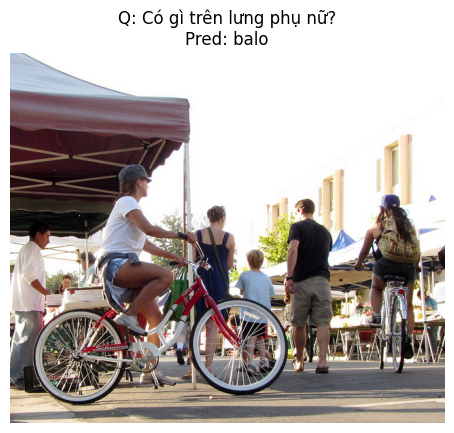

In [28]:
# Test ngẫu nhiên nhiều lần
test_random_sample(model, dataset, tokenizer, transform, idx_to_answer, show_image=True)

# ========== TEST NHẬP CÂU HỎI ==============

In [29]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import json

# Cấu hình các thư mục và thiết bị
IMAGE_DIR = '/kaggle/input/vqa-dataset/filtered_images'  # Thư mục ảnh
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hàm kiểm tra ảnh và hỏi nhiều câu
def test_random_image_with_questions(model, tokenizer, transform, idx_to_answer):
    # Lấy danh sách các file ảnh hợp lệ
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.png'))]
    if not image_files:
        print("❌ Không có ảnh trong thư mục.")
        return

    # Chọn ngẫu nhiên 1 ảnh
    selected_image_name = random.choice(image_files)
    image_path = os.path.join(IMAGE_DIR, selected_image_name)
    image_id = os.path.splitext(selected_image_name)[0]

    # Mở ảnh và chuyển thành tensor
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # Hiển thị ảnh
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Selected Image ID: {image_id}")
    plt.show()

    print(f"📷 Image: {selected_image_name} (ID: {image_id})")
    print("💬 Bạn có thể đặt nhiều câu hỏi liên quan đến ảnh. Gõ 'exit' để thoát.\n")

    # Lặp để người dùng nhập câu hỏi
    while True:
        question = input("❓ Nhập câu hỏi: ").strip()
        if question.lower() == 'exit':
            print("✅ Kết thúc.")
            break

        # Tokenize câu hỏi
        q_token = tokenizer(question, padding='max_length', truncation=True, max_length=32, return_tensors='pt')
        q_token = {k: v.to(DEVICE) for k, v in q_token.items()}

        # Dự đoán
        with torch.no_grad():
            logits = model(image_tensor, q_token)
            pred_idx = logits.argmax(dim=1).item()
            answer = idx_to_answer[pred_idx]

        print(f"🧠 Dự đoán: {answer}\n")

        # (Tuỳ chọn) hiển thị lại ảnh kèm câu hỏi/đáp án
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Q: {question}\nPredicted: {answer}")
        plt.show()


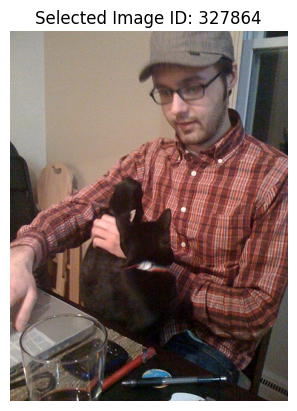

📷 Image: 327864.jpg (ID: 327864)
💬 Bạn có thể đặt nhiều câu hỏi liên quan đến ảnh. Gõ 'exit' để thoát.



❓ Nhập câu hỏi:  người đàn ông có đội mũ không?


🧠 Dự đoán: đúng



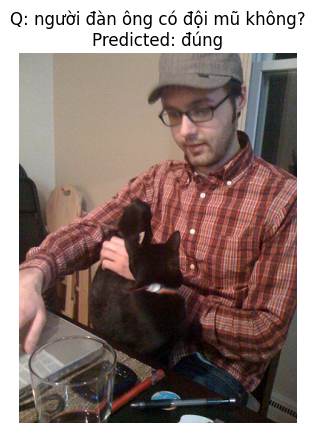

❓ Nhập câu hỏi:  con vật trên tay anh ấy là con gì


🧠 Dự đoán: con mèo



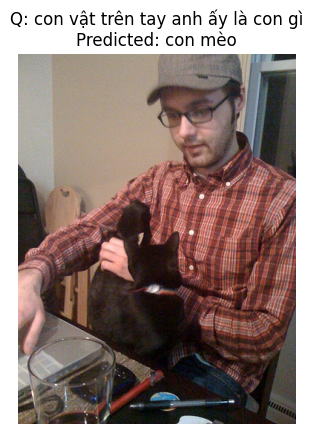

❓ Nhập câu hỏi:  cái ly có trên bàn không?


🧠 Dự đoán: đúng



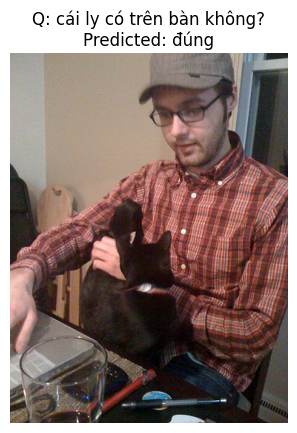

❓ Nhập câu hỏi:  exit


✅ Kết thúc.


In [35]:
test_random_image_with_questions(model, tokenizer, transform, idx_to_answer)